# Relaxation of 2 daughter cells after proliferation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi
import scipy.interpolate as sci

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 6.0  # final time
rA = 1.5   # maximum interaction distance

dim = 3
seed = 67

t_data = [0,tf]

#force_names = ['cubic', 'pw. quad.', 'GLS']
force = 'cubic'
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}


In [3]:
#algorithms
algorithms = ['EF_glob_adap_acc', 'EF_glob_adap_stab' , 'EB_global_adap' ]

models = {'EF_glob_adap_acc': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
          'EF_glob_adap_stab': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),  
          'EB_global_adap': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, dim) }

eta = 0.0001 

params = {'EF_glob_adap_acc': {'eta': eta},
#          'EF_glob_adap_stab': {'eta': eta, 'calculate_eigenvalues': True, 'write_to_file': True, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True}, 
          'EF_glob_adap_stab': {'eta': eta, 'jacobian': models['EF_glob_adap_stab'].jacobian, 'force_args': params_cubic, 'always_calculate_Jacobian': True}, 
          'EB_global_adap': {'eta': eta, 'jacobian': models['EB_global_adap'].jacobian, 'force_args': params_cubic}
         }


labels = {'EF_glob_adap_acc': 'Alg. I (SRFE)', 
          'EF_glob_adap_stab': 'Alg. II (SRFES)' ,  
          'EB_global_adap': 'Alg. IV (SRBE)'
         }

## Time step sizes as a function of chosen absolute error

In [4]:
cell_list = [cl.Cell(0, [0, 0, 0]), cl.Cell(1, [0.3, 0, 0])]

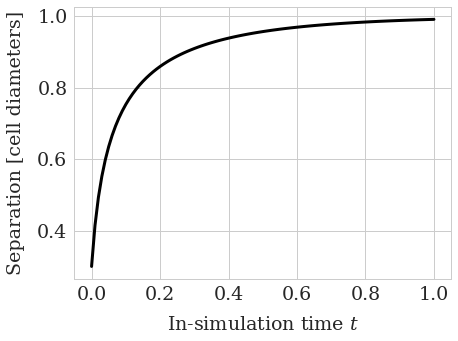

In [5]:
model = cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim)
ts, history = model.simulate(cell_list, [0, 1.0], params_cubic, {'dt':0.01}, seed=seed)

traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N, n_cells, dim)

plt.plot(ts, np.abs(traj[:, 1, 0] - traj[:, 0, 0]), color='black')
plt.ylabel('Separation [cell diameters]')
plt.xlabel(r'In-simulation time $t$')
plt.savefig('trajectories.png', bbox_inches='tight', dpi=600)

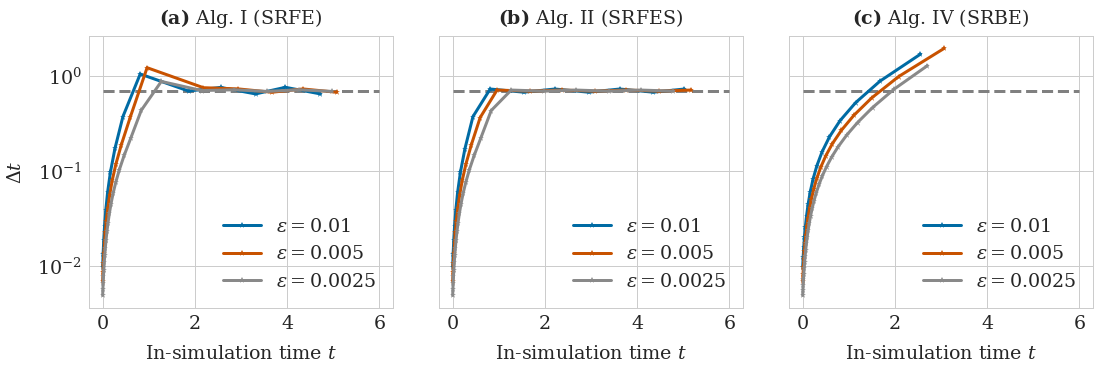

In [6]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 5),  sharey=True, gridspec_kw={'wspace': 0.15})


axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 ,  'EB_global_adap': ax3}

epsilons = [0.01, 0.005, 0.0025]

gp_cubic = params_cubic['mu']*(s-rA)**2
      
for alg in algorithms:
    
    axes[alg].plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color='grey' )
    
    for i, eps in enumerate(epsilons):
        
        params[alg]['eps'] = eps
        ts, history = models[alg].simulate(cell_list, t_data, params_cubic, params[alg], seed=seed)

        axes[alg].semilogy(ts[:-2], np.diff(ts)[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i]) # last dt smaller to reach end time exactly - do not plot
        
    axes[alg].legend()

ax1.set_title(r'$\bf{(a)}$ Alg. I (SRFE)')
ax2.set_title(r'$\bf{(b)}$ Alg. II (SRFES)')
#ax3.set_title(r'$\bf{(c)}$ Alg. III (MRFE)')
ax3.set_title(r'$\bf{(c)}$ Alg. IV (SRBE)')
    
ax1.set(ylabel=r'$\Delta t $')
#ax3.set(ylabel=r'$\Delta t $') 
ax1.set(xlabel=r'In-simulation time $t$')
ax2.set(xlabel=r'In-simulation time $t$')
ax3.set(xlabel=r'In-simulation time $t$')

plt.savefig('2cells_dt.pdf', bbox_inches='tight')

## Convergence study
We do the convergence study in 1D for convenience.

In [7]:
dim = 3
cell_list = [cl.Cell(0, [0, 0, 0]), cl.Cell(1, [0.3, 0, 0])]

In [8]:
# calculate reference solution
dt_ref = 0.00005
tf = 3.0
#N_ref = int(1/dt_ref*tf)+1

cbmodel = cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim)

ts_ref, history = cbmodel.simulate(cell_list, [0, tf], params_cubic, {'dt': dt_ref}, seed=seed)

ref_traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N_ref, n_cells, dim)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

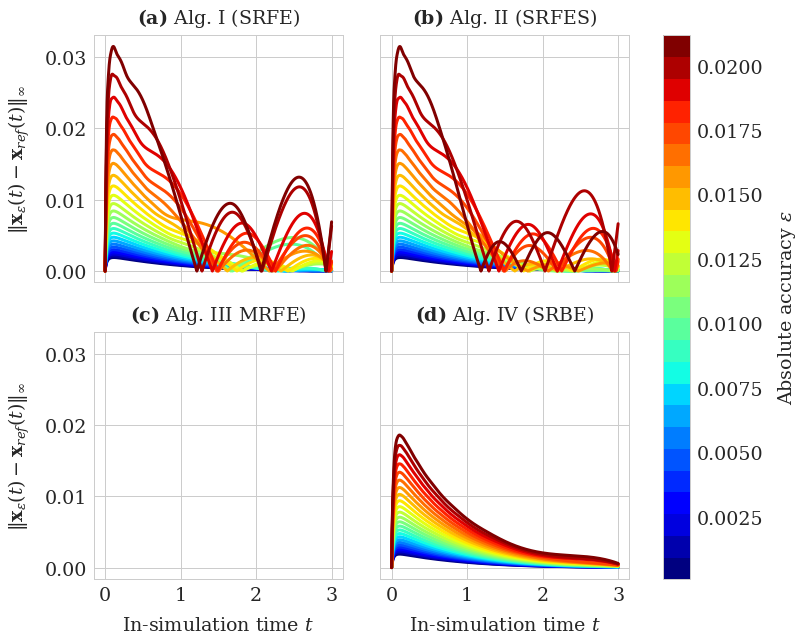

In [9]:
# Combine into single figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True, gridspec_kw={'hspace':0.2, 'wspace': 0.15})
      
axes = {'EF_glob_adap_acc': ax1, 'EF_glob_adap_stab': ax2 , 'EB_global_adap': ax4}

r = 25
eps_values = np.array([0.0001*1.25**n for n in range(0, r)])
map_eps_values_to_unit_interval = [ np.log(10000*(x-np.min(range(0, r))))/(np.max(range(0, r))-np.min(range(0, r)))/np.log(1.25) for x in eps_values]
colors = [ cm.jet(x) for x in map_eps_values_to_unit_interval ]

sol = {}
for alg in algorithms:
    
    for i, eps in enumerate(eps_values):
        
        params[alg]['eps'] = eps
        ts, history = models[alg].simulate(cell_list, [0, tf], params_cubic, params[alg], seed=seed)
        
        traj = np.array([[cell.position for cell in cell_list] for cell_list in history]) # (N, n_cells, dim)
        
        interp = sci.interp1d(ts, traj, axis=0, bounds_error=False, 
                              kind='cubic', fill_value=tuple(traj[[0, -1], :, :]))(ts_ref[:])
        difference = np.reshape(interp - ref_traj, (-1, dim*len(history[0])))
        
        error = np.linalg.norm(np.linalg.norm(difference, ord=np.inf, axis=1)/np.linalg.norm(np.reshape(ref_traj, (-1, dim*len(history[0]))), ord=np.inf, axis=1))
        sol.setdefault(alg, []).append(error)
            
        
        #axes[alg].plot(ts_ref, np.abs((interp[:, 1, 0] - interp[:, 0, 0])  - (ref_traj[:, 1, 0] - ref_traj[:, 0, 0])), color=colors[i])
        axes[alg].plot(ts_ref, np.linalg.norm(np.reshape(interp - ref_traj, (-1, dim*len(history[0]))), ord=np.inf, axis=1), color=colors[i])
        
        
#    axes[alg].legend()

ax1.set_title(r'$\bf{(a)}$ Alg. I (SRFE)')
ax2.set_title(r'$\bf{(b)}$ Alg. II (SRFES)')
ax3.set_title(r'$\bf{(c)}$ Alg. III MRFE)')
ax4.set_title(r'$\bf{(d)}$ Alg. IV (SRBE)')
    
ax1.set(ylabel=r'$\Vert \mathbf{x}_{\epsilon}(t)-\mathbf{x}_{ref}(t)\Vert_{\infty}$')
#ax1.set_ylim([-0.001, 0.045])
ax3.set(ylabel=r'$\Vert \mathbf{x}_{\epsilon}(t)-\mathbf{x}_{ref}(t)\Vert_{\infty}$')
#ax3.set_ylim([-0.001, 0.045])
ax3.set(xlabel=r'In-simulation time $t$')
ax4.set(xlabel=r'In-simulation time $t$')

cma = mcolors.ListedColormap(colors, name='from_list', N=None) # creation of a user cmap
msm = cm.ScalarMappable(cmap=cma) 
msm.set_array(eps_values) 
cbar = fig.colorbar(msm, ax=[ax1, ax2, ax3, ax4])
cbar.set_label('Absolute accuracy $\epsilon$', rotation=90)

plt.savefig('2cells_errors.pdf', bbox_inches='tight')

In [10]:
eps_values

array([0.0001    , 0.000125  , 0.00015625, 0.00019531, 0.00024414,
       0.00030518, 0.00038147, 0.00047684, 0.00059605, 0.00074506,
       0.00093132, 0.00116415, 0.00145519, 0.00181899, 0.00227374,
       0.00284217, 0.00355271, 0.00444089, 0.00555112, 0.00693889,
       0.00867362, 0.01084202, 0.01355253, 0.01694066, 0.02117582])

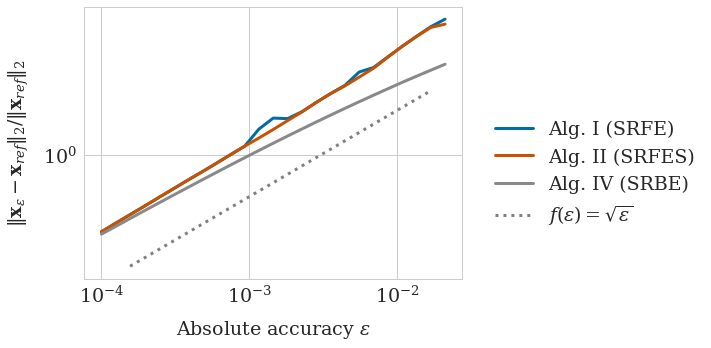

In [11]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

fig, ax = plt.subplots(1, figsize=(10, 5))
for i, alg in enumerate(algorithms):
    ax.loglog(eps_values, sol[alg], '-', label=labels[alg], color=colors[i])

ax.loglog(eps_values[2:-1], eps_values[2:-1]**0.5*18, ':',
           label='$f(\epsilon)= \sqrt{\epsilon}$', color='grey')
ax.set(xlabel='Absolute accuracy $\epsilon$')
ax.set(ylabel=r'$\Vert \mathbf{x}_{\epsilon}-\mathbf{x}_{ref}\Vert_{2}/\Vert \mathbf{x}_{ref}\Vert_{2}$')
fig.legend(loc=7)
fig.subplots_adjust(right=0.65)  
#plt.grid(True)
plt.savefig('2cells_order.pdf', bbox_inches='tight')

Estimate order of convergence:

In [12]:
from scipy.optimize import least_squares

In [13]:
def f(x, t, y):
    return x[0] * np.log(t) + x[1] - np.log(y)

In [14]:
res = least_squares(f, np.array([1,1]), args=(eps_values, sol['EF_glob_adap_acc']))

In [15]:
res.x

array([0.52961488, 3.83327965])

In [16]:
res_EB = least_squares(f, np.array([1,1]), args=(eps_values, sol['EB_global_adap']))

In [17]:
res_EB.x

array([0.42591599, 2.90415153])